In [1]:
import torch
print("Cuda_available? ", torch.cuda.is_available())
print("Name: ", torch.cuda.get_device_name(0))
print("Device count: ", torch.cuda.device_count())
print("current device: ", torch.cuda.current_device())
print("Select device: ", torch.cuda.device(0))
print("get device name: ",torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #finally got the solution

Cuda_available?  True
Name:  NVIDIA RTX A5000
Device count:  1
current device:  0
Select device:  <torch.cuda.device object at 0x7f9aab468cd0>
get device name:  NVIDIA RTX A5000


In [2]:
data_dir = 'data/ZIP'

In [3]:
import glob
import os
import nibabel as nib
from monai.data import CacheDataset,    Dataset,    DataLoader,    decollate_batch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from monai.inferers import sliding_window_inference
from monai.transforms import Resize
import numpy as np

In [4]:
images_pt = sorted(glob.glob(os.path.join(data_dir, 'PETCT*', '*', "SUV*")))
images_ct = sorted(glob.glob(os.path.join(data_dir, 'PETCT*', '*', "CTres*")))
images_sg = sorted(glob.glob(os.path.join(data_dir, 'PETCT*', '*', "SEG*")))
data_dicts = [
            {"image_pt": image_name_pt, "image_ct": image_name_ct, "image_sg": image_name_sg}
            for image_name_pt, image_name_ct, image_name_sg in zip(images_pt, images_ct, images_sg)
        ]
keys = ["image_pt", "image_ct", "image_sg"]
train_files, val_files = data_dicts[:70], data_dicts[70:]

In [5]:
from monai.transforms import (
Compose,
LoadImaged,
EnsureChannelFirstd,
Spacingd,
Orientationd,
ScaleIntensityRanged,
CropForegroundd,
ConcatItemsd,
DivisiblePadd,
AddChanneld,
RandCropByPosNegLabeld,
RandFlipd,EnsureTyped,
RandRotate90d,
RandShiftIntensityd,
Resized
)

In [6]:
crop_val = 96
train_transforms = Compose(
    [
        LoadImaged(keys=keys),
        AddChanneld(keys=keys),
        ScaleIntensityRanged(
            keys=["image_ct"], a_min=-100, a_max=250,
             b_min=0.0, b_max=1.0, clip=False,
        ),
        ScaleIntensityRanged(
            keys=["image_pt"], a_min=0, a_max=15,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        #CropForegroundd(keys=["image_ct", "image_pt"], source_key="image_ct"),
        Orientationd(keys=keys, axcodes="LAS"),
        # Resized(keys=keys, spatial_size=(256, 256, 256)), # resizing all keys
        ConcatItemsd(keys=["image_pt", "image_ct"], name="image_petct", dim=0),
        # Add some augmentations
        RandCropByPosNegLabeld(keys=["image_petct", "image_sg"], label_key="image_sg", spatial_size=(crop_val, crop_val, crop_val), pos=1, neg=1,
            num_samples=6,
            image_key="image_petct",
            image_threshold=0,
        ),
        RandRotate90d(
            keys=["image_petct", "image_sg"],
            prob=0.10,
            max_k=3,
        ),
        RandFlipd(
            keys=["image_petct", "image_sg"],
            spatial_axis=[0, 1, 2],
            prob=0.10,
        ),
        RandShiftIntensityd(
            keys=["image_petct"],
            offsets=0.10,
            prob=0.50,
        ),
        EnsureTyped(keys=["image_petct", "image_sg"]),
    ]
)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

In [7]:
val_transforms = Compose(
    [
        LoadImaged(keys=keys),
        AddChanneld(keys=keys),
        ScaleIntensityRanged(
            keys=["image_ct"], a_min=-100, a_max=250,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        ScaleIntensityRanged(
            keys=["image_pt"], a_min=0, a_max=15,
            b_min=0.0, b_max=1.0, clip=False,
        ),
        #CropForegroundd(keys=["image_ct", "image_pt"], source_key="image_ct"),
        Orientationd(keys=keys, axcodes="LAS"),
        # Resized(keys=keys, spatial_size=(256, 256, 256)), # resizing all keys
        ConcatItemsd(keys=["image_pt", "image_ct"], name="image_petct", dim=0),
        EnsureTyped(keys=["image_petct", "image_sg"]),
    ]
)


In [12]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.03)
#train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.05)
#val_ds = Dataset(data=val_files, transform=val_transforms)

Loading dataset: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


In [13]:
# Create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH
).to(device)

loss_function = DiceLoss(to_onehot_y=2, softmax=True)
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr)
dice_metric = DiceMetric(include_background=True, reduction="mean")

In [14]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader  = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=0)

In [15]:
#tranformation check
for batch_data in train_loader:
  label = batch_data["image_sg"]
  label = label != 0
        #print('The label values: ', np.unique(label))
  print(label.shape)

  inputs, labels = (
     batch_data["image_petct"].to(device),
     label.to(device),
  )
  print(inputs.shape)
  print(labels.shape)
  break

/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:561: UserWarning: Num foregrounds 0, Num backgrounds 19045437, unable to generate class balanced samples, setting `pos_ratio` to 0.
  warnings.warn(


torch.Size([6, 1, 96, 96, 96])
torch.Size([6, 2, 96, 96, 96])
torch.Size([6, 1, 96, 96, 96])


In [19]:
max_epochs = 50
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
checkpoint_path = os.path.join(data_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    epoch_loss_values = checkpoint['epoch_loss_values']
    metric_values = checkpoint['metric_values']
else:
    start_epoch = 0

for epoch in range(start_epoch,max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image_petct"].to(device),
            batch_data["image_sg"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if epoch % 6 == 0 :
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_metric': best_metric,
            'best_metric_epoch': best_metric_epoch,
            'epoch_loss_values': epoch_loss_values,
            'metric_values': metric_values
        }, checkpoint_path)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image_petct"].to(device),
                    val_data["image_sg"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(data_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 4/50
1/70, train_loss: 1.0000
2/70, train_loss: 0.9567
3/70, train_loss: 0.9852
4/70, train_loss: 1.0000
5/70, train_loss: 1.0000
6/70, train_loss: 0.9394
7/70, train_loss: 0.9998
8/70, train_loss: 0.9815
9/70, train_loss: 0.9443
10/70, train_loss: 0.9982
11/70, train_loss: 0.9969
12/70, train_loss: 0.9929
13/70, train_loss: 0.9527
14/70, train_loss: 0.6958
15/70, train_loss: 0.9919
16/70, train_loss: 1.0000
17/70, train_loss: 0.9884
18/70, train_loss: 0.9961
19/70, train_loss: 1.0000
20/70, train_loss: 0.9753
21/70, train_loss: 1.0000
22/70, train_loss: 0.9435
23/70, train_loss: 0.8303
24/70, train_loss: 0.9993
25/70, train_loss: 0.9972
26/70, train_loss: 0.9986
27/70, train_loss: 0.9990
28/70, train_loss: 0.9978
29/70, train_loss: 0.9958
30/70, train_loss: 0.9986
31/70, train_loss: 1.0000
32/70, train_loss: 0.9066
33/70, train_loss: 0.9541
34/70, train_loss: 0.7810
35/70, train_loss: 0.9908
36/70, train_loss: 0.9244
37/70, train_loss: 0.9856
38/70, train_loss: 0.9998

In [20]:
epoch

49

In [21]:
torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_metric': best_metric,
            'best_metric_epoch': best_metric_epoch,
            'epoch_loss_values': epoch_loss_values,
            'metric_values': metric_values
        }, checkpoint_path)

In [22]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.5256 at epoch: 1


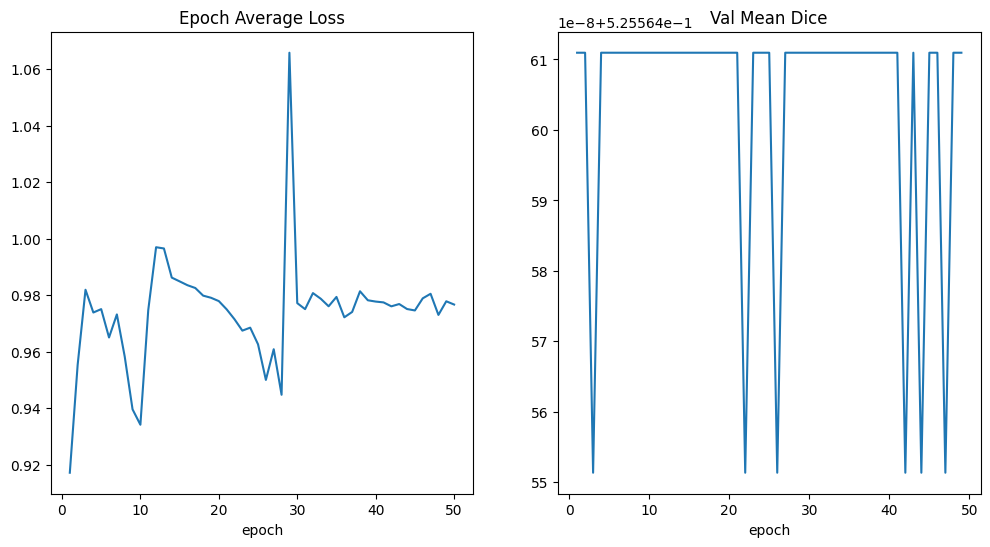

In [23]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

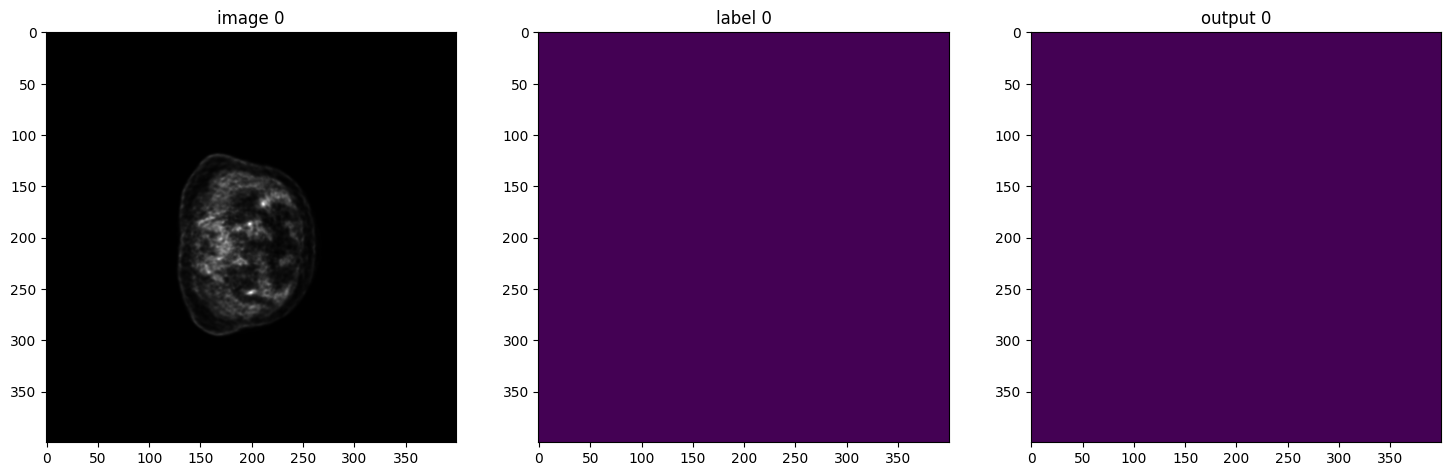

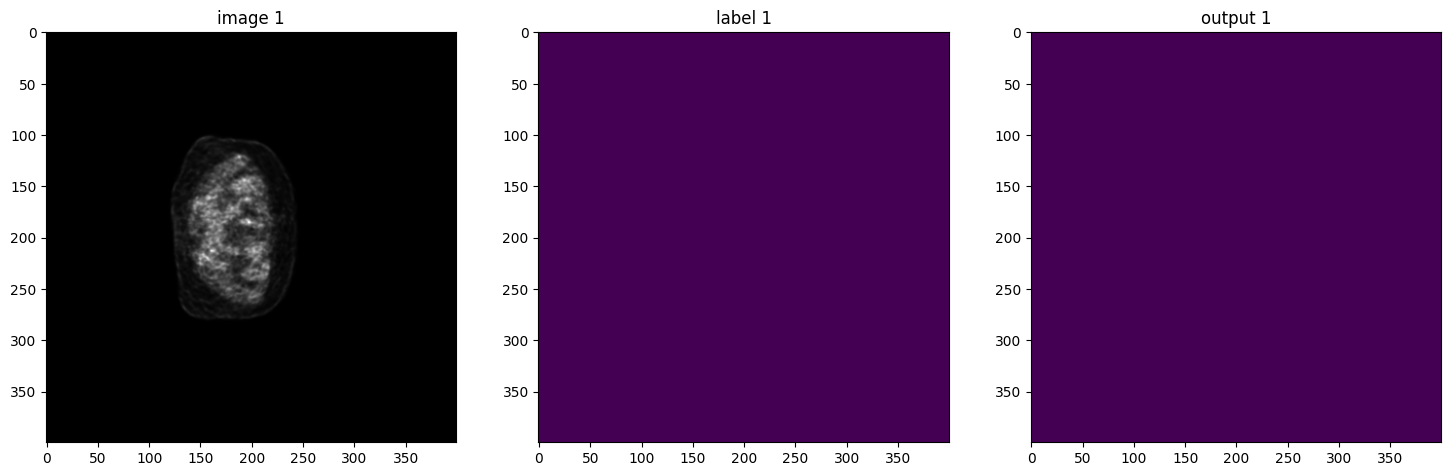

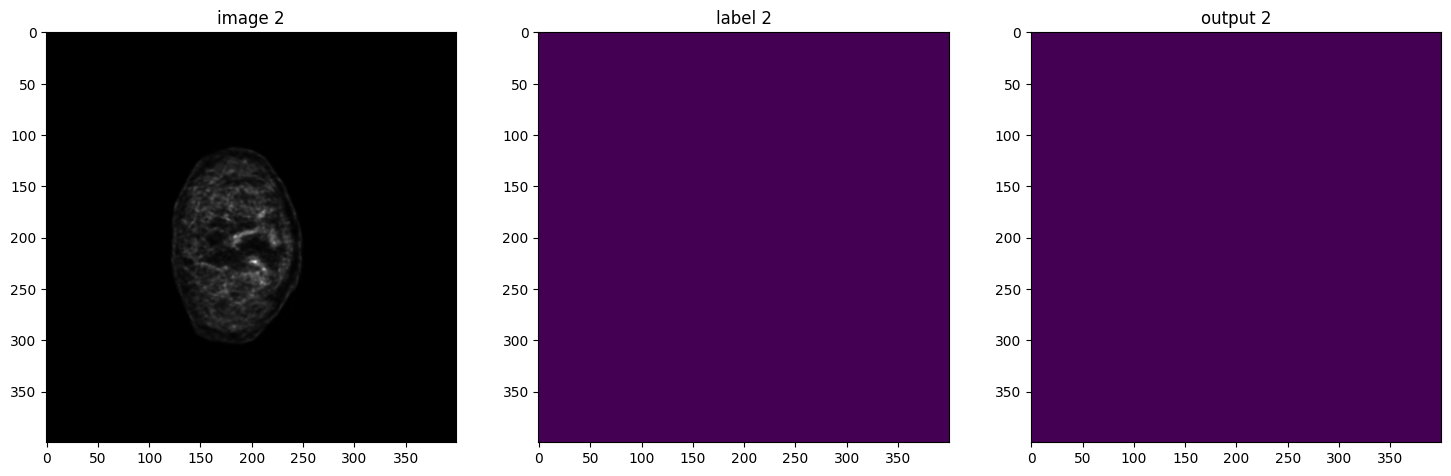

In [24]:
model.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image_petct"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image_petct"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["image_sg"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break